# **Medical Segmentation with U-Net**

Train and test the U-net model. Based on U-net implementation by [nikhilroxtomar](https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow).

## **Dataset**
Link: [Retina Blood Vessel](https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel/data)

## **Code**

### **Import libraries**

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam

### **Set up Colab environment**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Make sure to change the path if necessary!
%cd /content/gdrive/MyDrive/Unet

Mounted at /content/gdrive
/content/gdrive/MyDrive/Unet


### **Load and visualize data**

### *Load data*

In [3]:
def load_dataset(data_dir, imgsize=(256, 256)):
    # directory
    img_files = os.listdir(os.path.join(data_dir, 'image'))
    mask_files = os.listdir(os.path.join(data_dir, 'mask'))

    # Sort to synchronize input and ground truth
    img_files.sort()
    mask_files.sort()

    images = []
    masks = []

    # Load images and masks
    for img_file, mask_file in zip(img_files, mask_files):
        img_path = os.path.join(data_dir, 'image', img_file)
        mask_path = os.path.join(data_dir, 'mask', mask_file)

        # Read image and resize
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, imgsize)

        # Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = cv2.resize(mask, imgsize)

        # Pre-process by normalizing
        img = img/255.0
        mask = mask/255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [4]:
train_dir = "Data/train"
train_images, train_masks = load_dataset(train_dir)

test_dir = "Data/test"
test_images, test_masks = load_dataset(test_dir)

print(f"Train: Loaded {len(train_images)} images and {len(train_masks)} masks")
print("Image shape:", train_images[0].shape)
print("Mask shape:", train_masks[0].shape)

print(f"Test: Loaded {len(test_images)} images and {len(test_masks)} masks")
print("Image shape:", test_images[0].shape)
print("Mask shape:", test_masks[0].shape)

Train: Loaded 80 images and 80 masks
Image shape: (256, 256, 3)
Mask shape: (256, 256)
Test: Loaded 20 images and 20 masks
Image shape: (256, 256, 3)
Mask shape: (256, 256)


### *Visualize some random images*

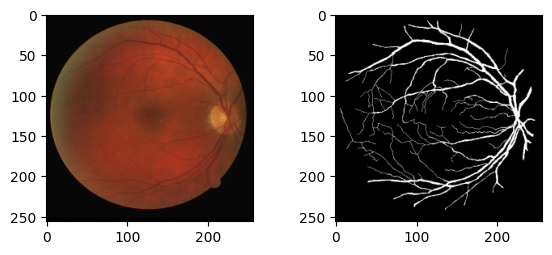

In [5]:
index = random.randint(0, len(train_images)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(train_images[index])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(train_masks[index], cmap="gray")
plt.show()

### **U-net model**

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p


def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


def UNet(input_size=(256, 256, 3)):
    #f = [16, 32, 64, 128, 256]
    f = [16, 32, 64, 128, 256]
    inputs = Input(input_size)

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    #c5, p5 = down_block(p4, f[4]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #8 -> 16
    u3 = up_block(u2, c2, f[1]) #16 -> 32
    u4 = up_block(u3, c1, f[0]) #32 -> 64
    #u5 = up_block(u4, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
model = UNet()

learning_rate = 0.002
optimizer = Adam(learning_rate=learning_rate)

model.load_weights("pretrained.h5")  # use pre-trained model if available
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

### **Train**

In [12]:
cb = [keras.callbacks.EarlyStopping(
    monitor="loss", min_delta=1e-3, patience=15, verbose=1
)]
model.fit(
    train_images, train_masks, batch_size=4, epochs=200, callbacks=cb
)

Epoch 1/200
20/20 [==============================] - 162s 3s/step - loss: 0.1094 - acc: 0.8663
Epoch 2/200
20/20 [==============================] - 58s 3s/step - loss: 0.0876 - acc: 0.8680
Epoch 3/200
20/20 [==============================] - 59s 3s/step - loss: 0.0802 - acc: 0.8683
Epoch 4/200
20/20 [==============================] - 59s 3s/step - loss: 0.0777 - acc: 0.8684
Epoch 5/200
20/20 [==============================] - 57s 3s/step - loss: 0.0766 - acc: 0.8684
Epoch 6/200
20/20 [==============================] - 58s 3s/step - loss: 0.0760 - acc: 0.8684
Epoch 7/200
20/20 [==============================] - 58s 3s/step - loss: 0.0757 - acc: 0.8684
Epoch 8/200
20/20 [==============================] - 60s 3s/step - loss: 0.0756 - acc: 0.8684
Epoch 9/200
20/20 [==============================] - 58s 3s/step - loss: 0.0754 - acc: 0.8684
Epoch 10/200
20/20 [==============================] - 58s 3s/step - loss: 0.0755 - acc: 0.8684
Epoch 11/200
20/20 [==============================] - 56s 

In [13]:
# Save weights
model.save_weights("weights.h5")

### **Test and assess**

In [14]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 4s 4s/step - loss: 0.1501 - acc: 0.8653
Test Loss: 0.15010851621627808
Test Accuracy: 0.8652687072753906


### **Predict**

1/1 [==============================] - 0s 270ms/step
False
1/1 [==============================] - 0s 279ms/step
False
1/1 [==============================] - 0s 275ms/step
False


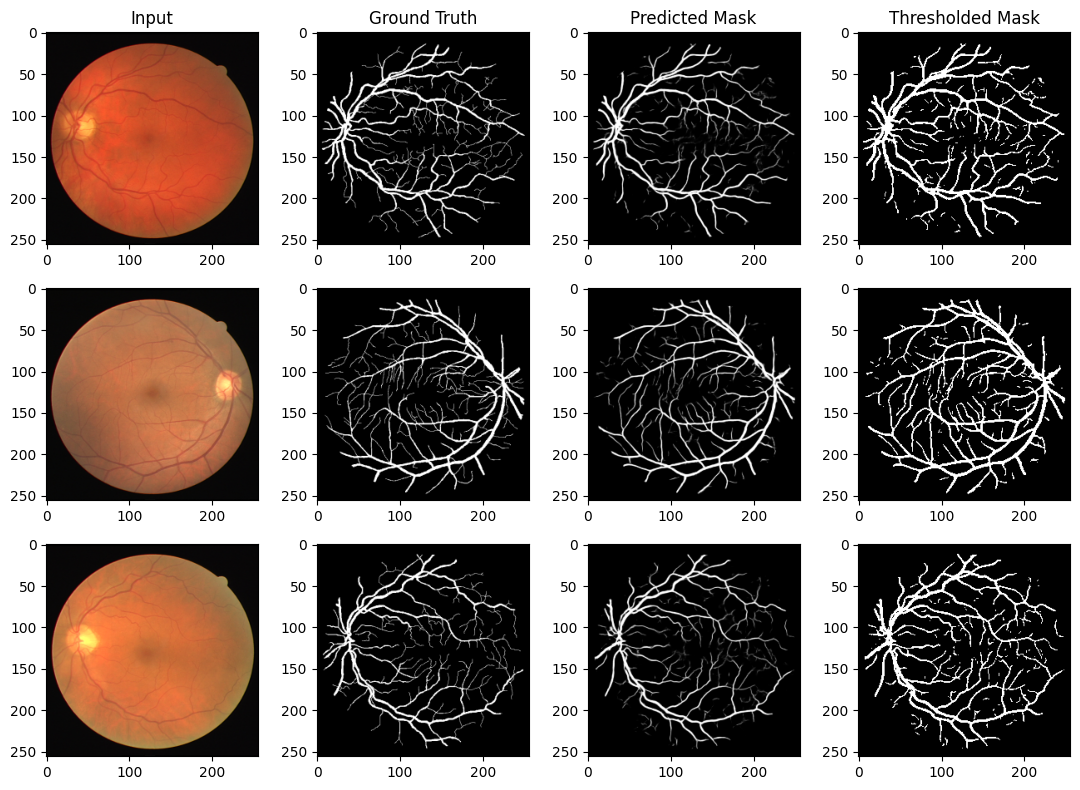

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(11, 8))

indices = np.random.choice(len(test_images), size=3, replace=False)
for r, index in enumerate(indices):
    test_image = test_images[index]
    test_mask = test_masks[index]
    test_data = test_images[np.newaxis, index]

    predicted_mask = model.predict(test_data)
    print(np.all(predicted_mask == 0))

    n_predicted_mask = predicted_mask > 0.16

    axes[r][0].imshow(test_image, cmap="gray")

    axes[r][1].imshow(test_mask, cmap="gray")

    axes[r][2].imshow(predicted_mask.squeeze(), cmap="gray")
    axes[r][3].imshow(n_predicted_mask.squeeze(), cmap="gray")

    if r == 0:
      axes[r][0].set_title('Input')
      axes[r][1].set_title('Ground Truth')
      axes[r][2].set_title('Predicted Mask')
      axes[r][3].set_title('Thresholded Mask')


# Adjust layout
plt.tight_layout()
plt.savefig("predictions_plt.png")
plt.show()